In [3]:
import numpy as np  
import matplotlib.pyplot as plt  
from PIL import Image

In [4]:
def distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))
def showImage(image_array):
    plt.imshow(image_array)  
    plt.axis('off')  
    plt.show() 
    
def replace_colors(reshaped_image, image_array, k_points):  
        distances = np.linalg.norm(reshaped_image[:, np.newaxis] - k_points[np.newaxis, :, :], axis=2)  
        closest_indices = np.argmin(distances, axis=1)  
        quantized_image = k_points[closest_indices].astype(np.uint8)
        return quantized_image.reshape(image_array.shape)  
def l2_norm(original, quantized):  
    return np.sum((original - quantized) ** 2)

In [5]:
class MyKMeans:  
    def __init__(self, n_clusters, max_iterations=-1, random_choose= 'random', visualization = False, log_flag = False, log_path ="L2_norm_log.txt"):  
        self.n_clusters = n_clusters  
        self.random_choose = random_choose
        self.max_iterations = max_iterations  
        self.log_flag = log_flag
        self.visualization = visualization
        self.reshaped_array = []
        self.log_path = log_path


    def initialize_k_points(self, array):  
        if self.random_choose == 'k_mean++':   
            initial_index = np.random.choice(len(array))  
            k_points = [array[initial_index]]  
  
            for _ in range(1, self.n_clusters):  
                k_points_array = np.array(k_points)  
                distances = np.linalg.norm(array[:, np.newaxis] - k_points_array, axis=2)  
                min_distances = distances.min(axis=1)  

                probabilities = min_distances ** 2  
                probabilities /= probabilities.sum()

                next_center_index = np.random.choice(len(array), p=probabilities)  
                k_points.append(array[next_center_index])  

            return np.array(k_points)  

        elif self.random_choose == 'random':  
            random_indices = np.random.choice(len(array), self.n_clusters, replace=False)  
            return array[random_indices]  


    def compute_clusters(self, k_points, array):  
        clusters = [[] for _ in range(len(k_points))]  
        distances = np.linalg.norm(array[:, np.newaxis] - k_points, axis=2)  
        closest_indices = np.argmin(distances, axis=1)  

        for idx, label in enumerate(closest_indices):  
            clusters[label].append(idx)  

        return clusters  


    def move_k_point(self, clusters, array):  
        new_points = []  
        for cluster in clusters:  
            if len(cluster) > 0:  
                new_points.append(np.mean(array[cluster], axis=0))  
            else:  
                new_points.append(np.random.choice(array, 1)[0])  
        return np.array(new_points)
   

    def fit(self, image_array):  
        self.reshaped_array = image_array.reshape(-1, 3)  

        if self.log_flag:  
            log_file = open(self.log_path, 'w')  

        k_points = self.initialize_k_points(self.reshaped_array)  
        iteration = 0  

        while True:  
            if iteration == self.max_iterations:  
                break  
            clusters = self.compute_clusters(k_points, self.reshaped_array)  
            k_points_new = self.move_k_point(clusters, self.reshaped_array)  

            if np.all(k_points_new == k_points):  
                break  
            
            k_points = k_points_new  
            iteration += 1  

            if self.log_flag:  
                outImg = replace_colors(self.reshaped_array, image_array, k_points)  
                original_image_reshaped = self.reshaped_array.reshape(image_array.shape)  # Keep the original shape  
                log_entry = str(l2_norm(original_image_reshaped.astype(np.float32), outImg.astype(np.float32))) + "\n"  
                log_file.write(log_entry)  

            if self.visualization:  
                showImage(replace_colors(self.reshaped_array, image_array, k_points))  

        if self.log_flag:  
            log_file.close()  

        return replace_colors(self.reshaped_array, image_array, k_points)


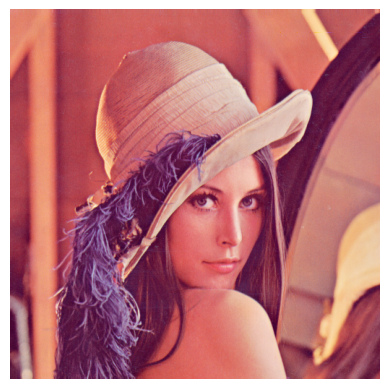

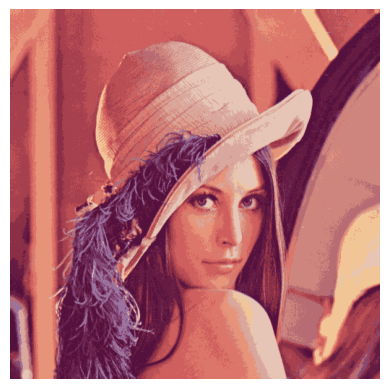

In [6]:
image_path = 'lena.png'
image = Image.open(image_path)
image = np.array(image)
plt.imshow(image)  
plt.axis('off')  
plt.show()  

k_mean = MyKMeans(16,max_iterations=20 , log_flag= True, log_path="l2 norm log lena.txt", random_choose='k_mean++')  
lena = k_mean.fit(image)
showImage(lena)

image = Image.fromarray(lena)
image.save('lena quantized.png')

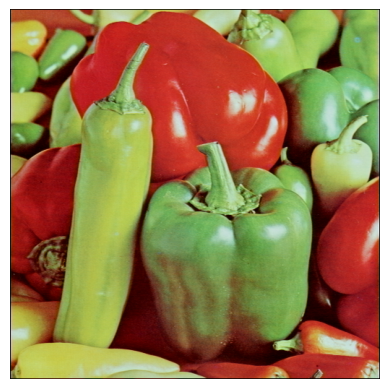

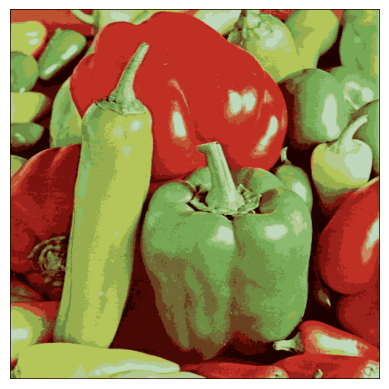

In [8]:
image_path = 'peppers.tif'
image = Image.open(image_path)
image = np.array(image)
plt.imshow(image)  
plt.axis('off')  
plt.show()  

k_mean = MyKMeans(16,max_iterations=20 , log_flag= True, log_path="l2 norm log peppers.txt", random_choose='k_mean++')  
peppers = k_mean.fit(image)
showImage(peppers)

image = Image.fromarray(peppers)
image.save('peppers quantized.png')